<a href="https://colab.research.google.com/github/christopherdiamana/nlp/blob/main/Previous/thomas_alia_kevin_huynh_simon_llagone_reda_sahrane.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="text-align:center;">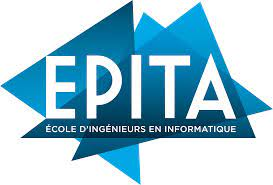
</p>


# Part 1. Keywords Extraction (14 points)

## What is Keyword Extraction?

Keyword extraction is defined as the task that automatically identifies a set of the terms that best describe the subject of document. This is an important method in information retrieval (IR) systems: keywords simplify and speed up the search. Keyword extraction can be used to reduce the dimensionality of text for further text analysis (text classification ot topic modeling). S.Art et al., for example, extracted keywords to measure patent similarity. Using keyword extraction, you can automatically index data, summarize a text, or generate tag clouds with the most representative keywords.

## How to extract the keywords?
All keyword extraction algorithms include the following steps:

* Candidate generation. Detection of possible candidate keywords from the text.
* Property calculation. Computation of properties and statistics required for ranking.
* Ranking. Computation of a score for each candidate keyword and sorting in descending order of all candidates. The top n candidates are finally selected as the n keywords representing the text.

In [ ]:
# all the imports 

import matplotlib.pyplot as plt

import numpy as np 
import pandas as pd 
import os

from IPython.core.display import HTML


from collections import Counter

## Goal.

In the following, given a paper, we will extract the keywords associated to this paper. Each individual can have their own qualitative assessment of what is "key" word. However, we will try as much as possible to objectify the approach and quantify to what extent a keyword is indeed key to the paper in question. 

## Loading data

In [ ]:
%%capture
! git clone https://github.com/MastafaF/ExtractKeywords.git

In [ ]:
import os

os.listdir("./ExtractKeywords")

['data.tar.gz', 'LICENSE', '.git', 'README.md']

In [ ]:
# Extract data file 

! cd ExtractKeywords && tar -zxvf data.tar.gz data

data/
data/papers.csv


In [ ]:
# load the dataset
df = pd.read_csv('./ExtractKeywords/data/papers.csv')
df.head()

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


## Preprocessing data 

In [ ]:
# For the Lemmatizer 
import nltk
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### Question 1.1: Preprocessing data in a meaningful way [code] (2 points)

In [ ]:
import re
from gensim.parsing.preprocessing import STOPWORDS

# Update stop words accordingly
#my_stop_words = STOPWORDS.union(set(['mystopword1', 'mystopword2']))

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

##Creating a list of custom stopwords
new_words = ["fig","figure","image","sample","using", 
             "show", "result", "large", 
             "also", "one", "two", "three", 
             "four", "five", "seven","eight","nine"]

stop_words = STOPWORDS.union(set(new_words))

def pre_process(text):
  regex = text.lower()
  regex = re.sub(r'[^a-z]+', ' ', regex)
  regex = re.sub(r'\b\w\b', ' ', regex)
  regex = re.sub(r'\b\w\w\b', ' ', regex)

  word_tokens = word_tokenize(regex)
  lemmatizer = WordNetLemmatizer()
  words_filtered = [w for w in word_tokens if not w in stop_words]

  return ' '.join([lemmatizer.lemmatize(w) for w in words_filtered])

In [ ]:
%%time

df['preproc_text'] = df['paper_text'].apply(pre_process)

CPU times: user 3min 7s, sys: 912 ms, total: 3min 8s
Wall time: 3min 8s


In [ ]:
# Visualizing data 
HTML(pd.DataFrame(df.loc[0, ["preproc_text"]]).to_html())

## 0. Raw counts



### Question 1.2: Build a top N words based on occurence [code] (1 point)

In [ ]:
"""
Idea: 

0. Split with spacy OR nltk 

1. Counter 

2. Surface top 10 

"""

def get_counter(txt_preproc, N=10): 
    tokens = word_tokenize(txt_preproc)
    bw = Counter(tokens)
    return bw.most_common(N)

df["Top N"] = df["preproc_text"].apply(get_counter)

In [ ]:
df.loc[2, "Top N"]

[('input', 58),
 ('weak', 42),
 ('synaptic', 36),
 ('associative', 35),
 ('ltp', 30),
 ('strong', 26),
 ('phase', 26),
 ('long', 24),
 ('stimulus', 23),
 ('hippocampus', 22)]

### Question 1.3: What are some of the limits of raw counts? How could we improve the approach through preprocessing? [written] (2 points)

* Limits: we are sometimes detecting words that are not relevant as keywords.

* How to improve: We need to improve preprocessing by adding more stop words to remove, and leave only the potential more relevant ones.

## 1. TF-IDF

### Introduction.

TF-IDF stands for Text Frequency Inverse Document Frequency. The importance of each word increases proportionally to the number of times a word appears in the document (Text Frequency - TF) but is offset by the frequency of the word in the corpus (Inverse Document Frequency - IDF). Using the tf-idf weighting scheme, the keywords are the words with the higherst TF-IDF score.

### CountVectorizer to create a vocabulary and generate word counts

In [ ]:
%%time
from sklearn.feature_extraction.text import CountVectorizer


#create a vocabulary of words, 
cv=CountVectorizer(max_df=0.95,         # ignore words that appear in 95% of documents
                   max_features=10000,  # the size of the vocabulary
                   ngram_range=(1,3)    # vocabulary contains single words, bigrams, trigrams
                  )


word_count_vector=cv.fit_transform(df["preproc_text"])

CPU times: user 2min 14s, sys: 4.07 s, total: 2min 18s
Wall time: 2min 18s


In [ ]:
word_count_vector

<7241x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 5593554 stored elements in Compressed Sparse Row format>

### TfidfTransformer to Compute Inverse Document Frequency (IDF)

In [ ]:
%%time
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer=TfidfTransformer(smooth_idf=True,
                                   use_idf=True)

tfidf_transformer.fit(word_count_vector)

CPU times: user 28.1 ms, sys: 3.02 ms, total: 31.1 ms
Wall time: 34.5 ms


In [ ]:
tfidf_transformer

TfidfTransformer()

### Question 1.4: How can you find an optimal max_df? Why are we using a sparse matrix instead of a regular matrix? [written] (2 points)

* Optimal max\_df: The dataset must be as much unbiased as possible with: a large number of documents that are the most representative of the whole language (i.e. well-weighted words apparitions).

* Sparse matrix: we are using it for storage and computing time performances.
  - Storage: There are lesser non-zero elements than zeros and thus lesser memory can be used to store only those elements.
  - Computing time: Computing time can be saved by logically designing a data structure traversing only non-zero elements.

In [ ]:
cv.transform([" change number node recognition rate defined relative frequency"])

<1x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 10 stored elements in Compressed Sparse Row format>

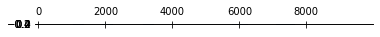

In [ ]:
# Visualizing data 
from scipy.sparse import csr_matrix

plt.spy(csr_matrix(cv.transform(["change number node recognition rate defined relative frequency"])))

In [ ]:
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

#generate tf-idf for the given document
tf_idf_vector=tfidf_transformer.transform(cv.transform(["change number node recognition rate defined relative frequency"]))

#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(tf_idf_vector.tocoo())

sorted_items

[(7342, 0.6387503245819366),
 (6082, 0.48227455357029786),
 (3278, 0.2826615514521735),
 (5942, 0.2670244641045569),
 (7332, 0.2285836952179592),
 (7472, 0.22171918342682348),
 (1176, 0.192004012179769),
 (7253, 0.17648064980292605),
 (2061, 0.15316537964943927),
 (6059, 0.12381100409601017)]

In [ ]:
coo_matrix = tf_idf_vector.tocoo()
# list(zip(coo_matrix.col, coo_matrix.data))
coo_matrix

<1x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 10 stored elements in COOrdinate format>

In [ ]:
# get feature names
feature_names=cv.get_feature_names()

def get_keywords(txt, top_N=10):

  # ------------------
  # Write your implementation here.
  #generate tf-idf for the given document
  tf_idf_vector=tfidf_transformer.transform(cv.transform([txt]))

  #sort the tf-idf vectors by descending order of scores
  sorted_items=sort_coo(tf_idf_vector.tocoo())[:top_N]

  sorted_items_features = list(map(lambda t: (feature_names[t[0]], 
                                         round(t[1], 3)), sorted_items))
  # ------------------
  
  return sorted_items_features

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
get_keywords(txt="change number node recognition rate defined relative frequency")

[('recognition rate', 0.639),
 ('number node', 0.482),
 ('frequency', 0.283),
 ('node', 0.267),
 ('recognition', 0.229),
 ('relative', 0.222),
 ('change', 0.192),
 ('rate', 0.176),
 ('defined', 0.153),
 ('number', 0.124)]

### Compare Raw Counts to Tf-IDF approach

In [ ]:
df["Top_N_TF-IDF"] = df["preproc_text"].apply(get_keywords, top_N=10)

In [ ]:
df.sample(3)

,id,year,title,event_type,pdf_name,abstract,paper_text,preproc_text,Top N,Top_N_TF-IDF
1308,2191,2002,Regularized Greedy Importance Sampling,NaN,2191-regularized-greedy-importance-sampling.pdf,Abstract Missing,Regularized Greedy Importance Sampling\n\nFinn...,regularized greedy importance sampling finnega...,"[(sampling, 48), (point, 48), (importance, 38)...","[(importance sampling, 0.429), (importance, 0...."
4785,5332,2014,Discrete Graph Hashing,Spotlight,5332-discrete-graph-hashing.pdf,Hashing has emerged as a popular technique for...,Discrete Graph Hashing\n\n?\n\nWei Liu? Cun Mu...,discrete graph hashing wei liu cun sanjiv kuma...,"[(hashing, 87), (dgh, 69), (code, 54), (hash, ...","[(hashing, 0.646), (hash, 0.417), (anchor, 0.2..."
652,1598,1998,Global Optimisation of Neural Network Models v...,NaN,1598-global-optimisation-of-neural-network-mod...,Abstract Missing,Global Optimisation of Neural Network\nModels ...,global optimisation neural network model seque...,"[(network, 29), (weight, 22), (model, 21), (se...","[(network weight, 0.279), (sequential, 0.272),..."


In [ ]:
df.iloc[157]

id                                                           1142
year                                                         1995
title                    Explorations with the Dynamic Wave Model
event_type                                                    NaN
pdf_name        1142-explorations-with-the-dynamic-wave-model.pdf
abstract                                         Abstract Missing
paper_text      Explorations with the Dynamic Wave\nModel\nTho...
preproc_text    exploration dynamic wave model thomas rebotier...
Top N           [(order, 18), (connection, 16), (wave, 12), (i...
Top_N_TF-IDF    [(wave, 0.375), (slope, 0.258), (connection, 0...
Name: 157, dtype: object

### Question 1.5: Find an example where there is a noticeable difference between tf-idf and raw counts? Justify which method you would choose yourself (there is no bad and good answer here) [written] (2 points)

* Noticeable difference between TF-IDF and raw counts can be seen on the following example:

In [ ]:
df.iloc[157]["preproc_text"]

'exploration dynamic wave model thomas rebotier jeffrey elman department cognitive science ucsd gilman jolla rebotier cogsci ucsd edu department cognitive science ucsd gilman jolla elman cogsci ucsd edu abstract following shrager johnson study growth logical function complexity network swept overlapping wave pruning hebbian reinforcement connection result indicate significant spatial gradient appearance linearly separable non linearly separable function input network cell sparser slope appearance sensitive parameter highly non linear way introduction complexity brain concomittant difficulty encoding plexity direct genetic mapping apparently high degree cortical plasticity suggest great deal cortical structure emergent pre specified neural model explored emergence complexity von der marlsburg studied grouping orientation selectivity competitive hebbian synaptic modification linsker showed spatial selection cell center surround orientation selective cell finally orientation column emerge

In [ ]:
df.iloc[157]["Top N"], df.iloc[157]["Top_N_TF-IDF"]

([('order', 18),
  ('connection', 16),
  ('wave', 12),
  ('input', 12),
  ('network', 11),
  ('function', 10),
  ('cell', 10),
  ('unit', 10),
  ('slope', 9),
  ('weight', 9)],
 [('wave', 0.375),
  ('slope', 0.258),
  ('connection', 0.252),
  ('pruning', 0.232),
  ('logical', 0.225),
  ('cell', 0.193),
  ('appearance', 0.159),
  ('order', 0.159),
  ('hebbian', 0.157),
  ('linearly separable', 0.144)])

* TF-IDF allows to get more relevant results than raw counts. It takes into account the frequency of the word in the text relatively to the inverse frequency of the whole corpus.

* In the below example, `order` appears the most in the text, so it is ranked first. However, using TF-IDF it is ranked 8th because it is a very common word in the whole corpus compared to `wave`.

## 2. KeyBERT

## 2.0. Installation

In [ ]:
%%capture
pip install keybert

In [ ]:
%%capture
from keybert import KeyBERT

doc = """
         Supervised learning is the machine learning task of learning a function that
         maps an input to an output based on example input-output pairs. It infers a
         function from labeled training data consisting of a set of training examples.
         In supervised learning, each example is a pair consisting of an input object
         (typically a vector) and a desired output value (also called the supervisory signal). 
         A supervised learning algorithm analyzes the training data and produces an inferred function, 
         which can be used for mapping new examples. An optimal scenario will allow for the 
         algorithm to correctly determine the class labels for unseen instances. This requires 
         the learning algorithm to generalize from the training data to unseen situations in a 
         'reasonable' way (see inductive bias).
      """
kw_model = KeyBERT()
keywords = kw_model.extract_keywords(doc)

In [ ]:
keywords

[('supervised', 0.6676),
 ('labeled', 0.4896),
 ('learning', 0.4813),
 ('training', 0.4134),
 ('labels', 0.3947)]

### Question 2.0. Apply KeyBERT to the a sample of the dataset [code] (1 point)

In [ ]:
df_ = df.sample(100)
df_.sample(1)

,id,year,title,event_type,pdf_name,abstract,paper_text,preproc_text,Top N,Top_N_TF-IDF
7236,994,1994,Single Transistor Learning Synapses,NaN,994-single-transistor-learning-synapses.pdf,Abstract Missing,Single Transistor Learning Synapses\n\nPaul Ha...,single transistor learning synapsis paul hasle...,"[(gate, 44), (weight, 42), (synapse, 42), (cur...","[(floating gate, 0.429), (gate, 0.333), (float..."


In [ ]:
%%time
%%capture


df_["Top_N_KeyBERT_1"] = df_["preproc_text"].apply(kw_model.extract_keywords, top_n=10)

CPU times: user 28.1 s, sys: 10.5 s, total: 38.6 s
Wall time: 27 s


In [ ]:
# TODO: compare the same paper example across the 3 methods 

idx_focus = 7236

print(df_.loc[idx_focus, "preproc_text"])
print("Keybert: ", df_.loc[idx_focus, "Top_N_KeyBERT_1"])
print("Raw count: ", df_.loc[idx_focus, "Top N"])
print("TF-IDF: ", df_.loc[idx_focus, "Top_N_TF-IDF"])

single transistor learning synapsis paul hasler chris diorio bradley minch carver mead california institute technology pasadena paul hobiecat pcmp caltech edu abstract single transistor silicon synapsis compute learn provide non volatile memory retention single transistor synapsis simultaneously perform long term weight storage compute product input weight value update weight value according hebbian backpropagation learning rule memory accomplished charge storage polysilicon floating gate providing long term retention refresh synapsis efficiently use physic silicon perform weight update weight value increased tunneling weight value decrease hot electron injection small size low power operation single transistor synapsis allows development dense synaptic array design fabrication characterization modeling array single transistor synapsis steady state source current representation weight value incrementing decrementing function proportional power source current synaptic array fabricated s

### Question 2.2. Comparison of multilple techniques [written] (4 points)

1. Draw a table of the solution, the quality score that you defined and the time taken to find keywords across a sample of 1000 of the original dataset. 
2. Can you think of tweaks to reduce time to compute? If yes, add an additional column to the above table with your proposed tweaks.
3. Based on the above table and  lecture 1, what do you think is the most appropriate solution for keywords extraction? Why? 

In [ ]:
df_1000 = df.sample(1000)

In [ ]:
%%time

df_1000["Top N"] = df_1000["preproc_text"].apply(get_counter)

CPU times: user 9.42 s, sys: 43.7 ms, total: 9.47 s
Wall time: 9.45 s


In [ ]:
%%time

df_1000["Top_N_TF-IDF"] = df_1000["preproc_text"].apply(get_keywords, top_N=10)

CPU times: user 7.16 s, sys: 47.2 ms, total: 7.21 s
Wall time: 7.17 s


In [ ]:
%%time

df_1000["Top_N_KeyBERT_1"] = df_1000["preproc_text"].apply(kw_model.extract_keywords, top_n=10)

CPU times: user 4min 36s, sys: 1min 45s, total: 6min 22s
Wall time: 4min 24s



1. In the doc

2. In the doc

3. 
*Although the Keybert technique requires much more time to generate the keywords using CPU, it is still the most appropriate for keywords extraction (the reasons are mentioned further below). Especially if we take advantage on **GPU** capabilities which in this case allows us to experience a significant decrease in computation time.*

* KeyBERT extraction is based on BERT (state of the art model) embeddings and cosine similarity
* BERT was designed to learn deep bidirectional representations of text segments
from an unlabed text.
* A model which is bidirectionally trained can have a **deeper sense of language context**
(both left and right context) and flow than single-direction language models.
* Researchers have repeatedly shown the value of **transfer learning**: pre-training a
neural network model on a large dataset, and then using it to perform similar tasks
on another dataset (with some fine-tuning).
* In the case of BERT we call it feature-based transfer learning consisting of a pre-trained neural network producing word embeddings which are then used as features in our custom NLP model.
* Since BERT embeddings had been **trained on a large text corpus**, our model starts to pick up the **deeper and intimate understandings** of how the language works.

# Part 2. Word Vectors (10 points)

In [ ]:
import sys

import numpy as np

from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import nltk
nltk.download('reuters')
from nltk.corpus import reuters
import numpy as np
import random
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

START_TOKEN = '<START>'
END_TOKEN = '<END>'

np.random.seed(0)
random.seed(0)

[nltk_data] Downloading package reuters to /root/nltk_data...


Word Vectors are often used as a fundamental component for downstream NLP tasks, e.g. question answering, text generation, translation, etc., so it is important to build some intuitions as to their strengths and weaknesses. Here, you will explore two types of word vectors: those derived from co-occurrence matrices, and those derived via GloVe.

Note on Terminology: The terms "word vectors" and "word embeddings" are often used interchangeably. The term "embedding" refers to the fact that we are encoding aspects of a word's meaning in a lower dimensional space. As Wikipedia states, "conceptually it involves a mathematical embedding from a space with one dimension per word to a continuous vector space with a much lower dimension".

## Count-Based Word Vectors

Most word vector models start from the following idea:

You shall know a word by the company it keeps (Firth, J. R. 1957:11)

Many word vector implementations are driven by the idea that similar words, i.e., (near) synonyms, will be used in similar contexts. As a result, similar words will often be spoken or written along with a shared subset of words, i.e., contexts. By examining these contexts, we can try to develop embeddings for our words. With this intuition in mind, many "old school" approaches to constructing word vectors relied on word counts. Here we elaborate upon one of those strategies, co-occurrence matrices.



## Plotting Co-Occurrence Word Embeddings


Here, we will be using the Reuters (business and financial news) corpus. If you haven't run the import cell at the top of this page, please run it now (click it and press SHIFT-RETURN). The corpus consists of 10,788 news documents totaling 1.3 million words. These documents span 90 categories and are split into train and test. For more details, please see https://www.nltk.org/book/ch02.html. We provide a read_corpus function below that pulls out only articles from the "crude" (i.e. news articles about oil, gas, etc.) category. The function also adds <START> and <END> tokens to each of the documents, and lowercases words. You do not have to perform any other kind of pre-processing.

In [ ]:
def read_corpus(category="crude"):
    """ Read files from the specified Reuter's category.
        Params:
            category (string): category name
        Return:
            list of lists, with words from each of the processed files
    """
    files = reuters.fileids(category)
    return [[START_TOKEN] + [w.lower() for w in list(reuters.words(f))] + [END_TOKEN] for f in files]

Let's have a look what these documents are like….

In [ ]:
%%capture
!unzip /root/nltk_data/corpora/reuters.zip -d /root/nltk_data/corpora

In [ ]:
reuters_corpus = read_corpus()
pprint.pprint(reuters_corpus[:3], compact=True, width=100)

[['<START>', 'japan', 'to', 'revise', 'long', '-', 'term', 'energy', 'demand', 'downwards', 'the',
  'ministry', 'of', 'international', 'trade', 'and', 'industry', '(', 'miti', ')', 'will', 'revise',
  'its', 'long', '-', 'term', 'energy', 'supply', '/', 'demand', 'outlook', 'by', 'august', 'to',
  'meet', 'a', 'forecast', 'downtrend', 'in', 'japanese', 'energy', 'demand', ',', 'ministry',
  'officials', 'said', '.', 'miti', 'is', 'expected', 'to', 'lower', 'the', 'projection', 'for',
  'primary', 'energy', 'supplies', 'in', 'the', 'year', '2000', 'to', '550', 'mln', 'kilolitres',
  '(', 'kl', ')', 'from', '600', 'mln', ',', 'they', 'said', '.', 'the', 'decision', 'follows',
  'the', 'emergence', 'of', 'structural', 'changes', 'in', 'japanese', 'industry', 'following',
  'the', 'rise', 'in', 'the', 'value', 'of', 'the', 'yen', 'and', 'a', 'decline', 'in', 'domestic',
  'electric', 'power', 'demand', '.', 'miti', 'is', 'planning', 'to', 'work', 'out', 'a', 'revised',
  'energy', 'supply

### Question 2.1: Implement distinct_words [code] (2 points)

Write a method to work out the distinct words (word types) that occur in the corpus. You can do this with for loops, but it's more efficient to do it with Python list comprehensions. In particular, this may be useful to flatten a list of lists. If you're not familiar with Python list comprehensions in general, here's more information.

Your returned corpus_words should be sorted. You can use python's sorted function for this.

You may find it useful to use Python sets to remove duplicate words.

In [ ]:
def distinct_words(corpus):
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents - eg [["hey", "I", "am", "toto"], ["hey", "I", "am", "tata"]]
        Return:
            corpus_words (list of strings): sorted list of distinct words across the corpus
            num_corpus_words (integer): number of distinct words across the corpus
    """
    corpus_words = []
    num_corpus_words = -1
    
    # ------------------

    corpus_words = list(sorted(set(([word for sublist in corpus for word in sublist]))))
    num_corpus_words = len(corpus_words)

    return corpus_words, num_corpus_words

    # ------------------


In [ ]:
# ---------------------
# Run this sanity check
# Note that this not an exhaustive check for correctness.
# ---------------------

# Define toy corpus
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
test_corpus_words, num_corpus_words = distinct_words(test_corpus)

# Correct answers
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
ans_num_corpus_words = len(ans_test_corpus_words)

# Test correct number of words
assert(num_corpus_words == ans_num_corpus_words), "Incorrect number of distinct words. Correct: {}. Yours: {}".format(ans_num_corpus_words, num_corpus_words)

# Test correct words
assert (test_corpus_words == ans_test_corpus_words), "Incorrect corpus_words.\nCorrect: {}\nYours:   {}".format(str(ans_test_corpus_words), str(test_corpus_words))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 2.2: Implement compute_co_occurrence_matrix [code] (3 points)

Write a method that constructs a co-occurrence matrix for a certain window-size  n  (with a default of 4), considering words  n  before and  n  after the word in the center of the window. Here, we start to use numpy (np) to represent vectors, matrices, and tensors

In [ ]:
from collections import defaultdict
from collections import Counter 

def compute_co_occurrence_matrix(corpus, window_size=4):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).
    
        Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
              number of co-occurring words.
              
              For example, if we take the document "<START> All that glitters is not gold <END>" with window size of 4,
              "All" will co-occur with "<START>", "that", "glitters", "is", and "not".
    
        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
        Return:
            M (a symmetric numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): 
                Co-occurence matrix of word counts. 
                The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
            word2ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
    """
    words, num_words = distinct_words(corpus)
    M = None
    word2ind = {}
    
    
    # ------------------
    word2ind = dict(zip(words, range(len(words))))
    length = len(word2ind)

    M = np.zeros([length, length])

    def calc_occu(sentence):
      for (i, word) in enumerate(sentence):
          for j in range(max(i - window_size, 0), min(i + window_size + 1, len(sentence))):
              if j != i:
                M[word2ind[word], word2ind[sentence[j]]] += 1

    for sentence in corpus:
      calc_occu(sentence)
    # ------------------

    return M, word2ind

In [ ]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# ---------------------

# Define toy corpus and get student's co-occurrence matrix
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)

# Correct M and word2ind
M_test_ans = np.array( 
    [[0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,],
     [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,],
     [1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,],
     [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,],
     [0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,],
     [1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,]]
)


ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
word2ind_ans = dict(zip(ans_test_corpus_words, range(len(ans_test_corpus_words))))

# Test correct word2ind
assert (word2ind_ans == word2ind_test), "Your word2ind is incorrect:\nCorrect: {}\nYours: {}".format(word2ind_ans, word2ind_test)

# Test correct M shape
assert (M_test.shape == M_test_ans.shape), "M matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(M_test.shape, M_test_ans.shape)

# Test correct M values
for w1 in word2ind_ans.keys():
    idx1 = word2ind_ans[w1]
    for w2 in word2ind_ans.keys():
        idx2 = word2ind_ans[w2]
        student = M_test[idx1, idx2]
        correct = M_test_ans[idx1, idx2]
        if student != correct:
            print("Correct M:")
            print(M_test_ans)
            print("Your M: ")
            print(M_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix M. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student, correct))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 2.3: Implement reduce_to_k_dim [code] (1 point)

Construct a method that performs dimensionality reduction on the matrix to produce k-dimensional embeddings. Use SVD to take the top k components and produce a new matrix of k-dimensional embeddings.

Note: All of numpy, scipy, and scikit-learn (sklearn) provide some implementation of SVD, but only scipy and sklearn provide an implementation of Truncated SVD, and only sklearn provides an efficient randomized algorithm for calculating large-scale Truncated SVD. So please use sklearn.decomposition.TruncatedSVD.

In [ ]:
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    
        Params:
            M (numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """    
    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    
    # ------------------

    svd = TruncatedSVD(n_components=k, n_iter=n_iters, random_state=42)
    M_reduced = svd.fit_transform(M)

    # ------------------

    print("Done.")
    return M_reduced

In [ ]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness 
# In fact we only check that your M_reduced has the right dimensions.
# ---------------------

# Define toy corpus and run student code
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)
M_test_reduced = reduce_to_k_dim(M_test, k=2)

# Test proper dimensions
assert (M_test_reduced.shape[0] == 10), "M_reduced has {} rows; should have {}".format(M_test_reduced.shape[0], 10)
assert (M_test_reduced.shape[1] == 2), "M_reduced has {} columns; should have {}".format(M_test_reduced.shape[1], 2)

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

Running Truncated SVD over 10 words...
Done.
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


In [ ]:
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)
M_test_reduced = reduce_to_k_dim(M_test, k=2)
M_test_reduced

Running Truncated SVD over 10 words...
Done.


array([[ 6.54802087e-01, -7.83221122e-01],
       [ 5.20200324e-01,  3.60822483e-16],
       [ 7.05647176e-01,  4.84057274e-01],
       [ 7.05647176e-01, -4.84057274e-01],
       [ 1.02780472e+00,  3.33066907e-16],
       [ 6.54802087e-01,  7.83221122e-01],
       [ 3.82258491e-01,  6.56224003e-01],
       [ 3.82258491e-01, -6.56224003e-01],
       [ 1.39420808e+00, -1.06179274e+00],
       [ 1.39420808e+00,  1.06179274e+00]])

### Question 2.4: Implement plot_embeddings [code] (1 point)

Here you will write a function to plot a set of 2D vectors in 2D space. For graphs, we will use Matplotlib (plt).

For this example, you may find it useful to adapt this code. In the future, a good way to make a plot is to look at the Matplotlib gallery, find a plot that looks somewhat like what you want, and adapt the code they give.

In [ ]:
def plot_embeddings(M_reduced, word2ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2ind.
        Include a label next to each point.
        
        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus , 2)): matrix of 2-dimensioal word embeddings
            word2ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """


    # ------------------
    # Write your implementation here.

    for word in words:
      ind = word2ind[word]
      y, x = M_reduced[ind][0], M_reduced[ind][1]
      plt.scatter(x, y, s=300, c=1, alpha=0.5)
      plt.annotate(word, (x, y))

    plt.show()

    # ------------------

--------------------------------------------------------------------------------
Outputted Plot:


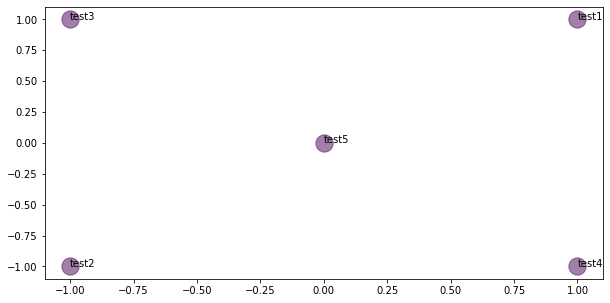

--------------------------------------------------------------------------------


In [ ]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# The plot produced should look like the "test solution plot" depicted below. 
# ---------------------

print ("-" * 80)
print ("Outputted Plot:")

M_reduced_plot_test = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]])
word2ind_plot_test = {'test1': 0, 'test2': 1, 'test3': 2, 'test4': 3, 'test5': 4}
words = ['test1', 'test2', 'test3', 'test4', 'test5']
plot_embeddings(M_reduced_plot_test, word2ind_plot_test, words)

print ("-" * 80)

### Question 2.5: Co-Occurrence Plot Analysis [written] (3 points)

Now we will put together all the parts you have written! We will compute the co-occurrence matrix with fixed window of 4 (the default window size), over the Reuters "crude" (oil) corpus. Then we will use TruncatedSVD to compute 2-dimensional embeddings of each word. TruncatedSVD returns U*S, so we need to normalize the returned vectors, so that all the vectors will appear around the unit circle (therefore closeness is directional closeness). Note: The line of code below that does the normalizing uses the NumPy concept of broadcasting. If you don't know about broadcasting, check out Computation on Arrays: Broadcasting by Jake VanderPlas.

Run the below cell to produce the plot. It'll probably take a few seconds to run. What clusters together in 2-dimensional embedding space? What doesn't cluster together that you might think should have? Note: "bpd" stands for "barrels per day" and is a commonly used abbreviation in crude oil topic articles.

Running Truncated SVD over 8185 words...
Done.


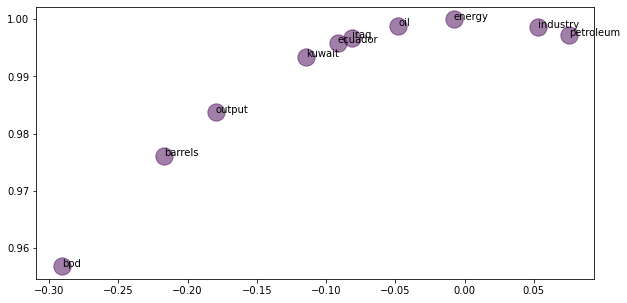

In [ ]:
# -----------------------------
# Run This Cell to Produce Your Plot
# ------------------------------
reuters_corpus = read_corpus()
M_co_occurrence, word2ind_co_occurrence = compute_co_occurrence_matrix(reuters_corpus)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting

words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']

plot_embeddings(M_normalized, word2ind_co_occurrence, words)

**There are three small clusters that appear clearly on the plot above:**
1. Oil industry: Industry, petroleum
2. Energies: Energy, oil
3. Oil-producing countries: Kuwai, ecuador, iraq

**What doesn't cluster together:**
1. Barrels and bpd should have clustered together

# Part 3. Prediction-based word vectors (15 points)

As discussed in class, more recently prediction-based word vectors have demonstrated better performance, such as word2vec and GloVe (which also utilizes the benefit of counts). If you're feeling adventurous, challenge yourself and try reading GloVe's original paper.

Then run the following cells to load the GloVe vectors into memory. Note: If this is your first time to run these cells, i.e. download the embedding model, it will take a couple minutes to run. If you've run these cells before, rerunning them will load the model without redownloading it, which will take about 1 to 2 minutes.

In [ ]:
def load_embedding_model():
    """ Load GloVe Vectors
        Return:
            wv_from_bin: All 400000 embeddings, each lengh 200
    """
    import gensim.downloader as api
    wv_from_bin = api.load("glove-wiki-gigaword-200")
    print("Loaded vocab size %i" % len(wv_from_bin.vocab.keys()))
    return wv_from_bin

In [ ]:
# -----------------------------------
# Run Cell to Load Word Vectors
# Note: This will take a couple minutes
# -----------------------------------
wv_from_bin = load_embedding_model()

[==================================================] 100.0% 252.1/252.1MB downloaded
Loaded vocab size 400000


#### Note: If you are receiving a "reset by peer" error, rerun the cell to restart the download.

## Reducing dimensionality of Word Embeddings

Let's directly compare the GloVe embeddings to those of the co-occurrence matrix. In order to avoid running out of memory, we will work with a sample of 10000 GloVe vectors instead. Run the following cells to:

Put 10000 Glove vectors into a matrix M
Run reduce_to_k_dim (your Truncated SVD function) to reduce the vectors from 200-dimensional to 2-dimensional.

In [ ]:
def get_matrix_of_vectors(wv_from_bin, required_words=['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']):
    """ Put the GloVe vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 400000 GloVe vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 200) containing the vectors
            word2ind: dictionary mapping each word to its row number in M
    """
    import random
    words = list(wv_from_bin.vocab.keys())
    print("Shuffling words ...")
    random.seed(224)
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2ind and matrix M..." % len(words))
    word2ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.word_vec(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        if w in words:
            continue
        try:
            M.append(wv_from_bin.word_vec(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2ind

In [ ]:
# -----------------------------------------------------------------
# Run Cell to Reduce 200-Dimensional Word Embeddings to k Dimensions
# Note: This should be quick to run
# -----------------------------------------------------------------
M, word2ind = get_matrix_of_vectors(wv_from_bin)
M_reduced = reduce_to_k_dim(M, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced, axis=1)
M_reduced_normalized = M_reduced / M_lengths[:, np.newaxis] # broadcasting

Shuffling words ...
Putting 10000 words into word2ind and matrix M...
Done.
Running Truncated SVD over 10010 words...
Done.


### Question 3.1: GloVe Plot Analysis [written] (3 points)

Run the cell below to plot the 2D GloVe embeddings for ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq'].

What clusters together in 2-dimensional embedding space? What doesn't cluster together that you think should have? How is the plot different from the one generated earlier from the co-occurrence matrix? What is a possible cause for the difference?

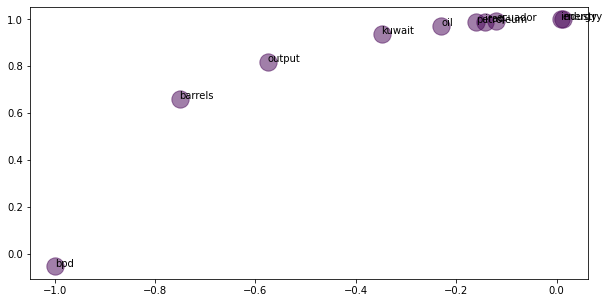

In [ ]:
words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']
plot_embeddings(M_reduced_normalized, word2ind, words)

* What clusters together (2 main clusters):
  - industry and energy
  - ecuador-iraq-petroleum; kuwait-oil
* What should have clustered together: 
  - ecuador-iraq with kuwait
  - energy with petroleum
  - bpd with barrels
* This plot is different from the other because the three clusters are not arranged in the same way. 
* This may be caused by the fact that we didn't use the same dataset vocabulary to generate the word vectors hence the differences in the coo-occurrence matrices.

## Cosine Similarity

Now that we have word vectors, we need a way to quantify the similarity between individual words, according to these vectors. One such metric is cosine-similarity. We will be using this to find words that are "close" and "far" from one another.

We can think of n-dimensional vectors as points in n-dimensional space. If we take this perspective L1 and L2 Distances help quantify the amount of space "we must travel" to get between these two points. Another approach is to examine the angle between two vectors. From trigonometry we know that:

### Question 3.2: Words with Multiple Meanings (1.5 points) [code + written]

Polysemes and homonyms are words that have more than one meaning (see this wiki page to learn more about the difference between polysemes and homonyms ). Find a word with at least two different meanings such that the top-10 most similar words (according to cosine similarity) contain related words from both meanings. For example, "leaves" has both "go_away" and "a_structure_of_a_plant" meaning in the top 10, and "scoop" has both "handed_waffle_cone" and "lowdown". You will probably need to try several polysemous or homonymic words before you find one.

Please state the word you discover and the multiple meanings that occur in the top 10. Why do you think many of the polysemous or homonymic words you tried didn't work (i.e. the top-10 most similar words only contain one of the meanings of the words)?

Note: You should use the wv_from_bin.most_similar(word) function to get the top 10 similar words. This function ranks all other words in the vocabulary with respect to their cosine similarity to the given word. For further assistance, please check the GenSim documentation.

In [ ]:
# Case when a word have 2 different meanings but top10 most similars words only find one meaning

word = "bright"
wv_from_bin.most_similar(word)

[('colors', 0.6588894724845886),
 ('yellow', 0.6551189422607422),
 ('dark', 0.6530420780181885),
 ('blue', 0.6525461077690125),
 ('brighter', 0.6521291136741638),
 ('brightly', 0.6383564472198486),
 ('colored', 0.6271968483924866),
 ('light', 0.6242774724960327),
 ('green', 0.6158419847488403),
 ('pink', 0.6027827262878418)]

In [ ]:
# Case when a word have 2 different meanings and top10 most similars words find the two meanings

word = "left"
wv_from_bin.most_similar(word)

[('leaving', 0.8048900961875916),
 ('right', 0.716508150100708),
 ('back', 0.7087967991828918),
 ('went', 0.6952050924301147),
 ('out', 0.6867293119430542),
 ('leave', 0.6815778017044067),
 ('when', 0.677730917930603),
 ('returned', 0.6693609952926636),
 ('came', 0.6677365899085999),
 ('but', 0.662541389465332)]

* The word discovered is `left` and has two meanings in the top-10: the direction and the verb which is an action (to leave).
* We also tried `bright` (polysemus) that has two slightly related meanings: smart and the light intensity, however it didn't worked for this example. The top-10 most similar words on this word doesn't reflect anything in the lexical scope of "intelligence".
* For homononyms we have a difference in meaning between two words that can be susbtantial in that case the top-10 often works, however for polyseme the difference is more subtle hence the difficulty to catch all the meanings.

### Question 3.3: Synonyms & Antonyms (2 points) [code + written]

When considering Cosine Similarity, it's often more convenient to think of Cosine Distance, which is simply 1 - Cosine Similarity.

Find three words  (w1,w2,w3)  where  w1  and  w2  are synonyms and  w1  and  w3  are antonyms, but Cosine Distance  (w1,w3)<  Cosine Distance  (w1,w2) .

As an example,  w1 ="happy" is closer to  w3 ="sad" than to  w2 ="cheerful". Please find a different example that satisfies the above. Once you have found your example, please give a possible explanation for why this counter-intuitive result may have happened.

You should use the the wv_from_bin.distance(w1, w2) function here in order to compute the cosine distance between two words. Please see the GenSim documentation for further assistance.

In [ ]:
    # ------------------
    # Write your implementation here.
word1 = "strong"
word2 = "powerful" # Synonym of word1
word3 = "weak" # Antonym of word1


print("Cosine distance between synonym: ", wv_from_bin.distance(word1, word2))
print("Cosine distance between antonym: ", wv_from_bin.distance(word1, word3))

    # ------------------

Cosine distance between synonym:  0.3854295015335083
Cosine distance between antonym:  0.3302966356277466


* Two antonyms may potentially have a cosine distance lower than two synonyms.
* For example, we took `strong` and `weak`, with: $$cosDist(strong, weak) < cosDist(strong, powerful)$$ \\

Why do we get this result ?
* Because, in the case of `strong` and `weak` they are found very regularly in the same contexts with similar sentence compositions.

### Question 3.4: Analogies with Word Vectors [written] (1.5 points)

Word vectors have been shown to sometimes exhibit the ability to solve analogies.

As an example, for the analogy "man : king :: woman : x" (read: man is to king as woman is to x), what is x?

x is the Queen

In the cell below, we show you how to use word vectors to find x using the most_similar function from the GenSim documentation. The function finds words that are most similar to the words in the positive list and most dissimilar from the words in the negative list (while omitting the input words, which are often the most similar; see this paper). The answer to the analogy will have the highest cosine similarity (largest returned numerical value).

In [ ]:
# Run this cell to answer the analogy -- man : king :: woman : x
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'king'], negative=['man']))

[('queen', 0.6978678703308105),
 ('princess', 0.6081745028495789),
 ('monarch', 0.5889754891395569),
 ('throne', 0.5775108933448792),
 ('prince', 0.5750998854637146),
 ('elizabeth', 0.546359658241272),
 ('daughter', 0.5399125814437866),
 ('kingdom', 0.5318052768707275),
 ('mother', 0.5168544054031372),
 ('crown', 0.5164472460746765)]


Let  m ,  k ,  w , and  x  denote the word vectors for man, king, woman, and the answer, respectively. Using only vectors  m ,  k ,  w , and the vector arithmetic operators  +  and  −  in your answer, what is the expression in which we are maximizing cosine similarity with  x ?

Hint: Recall that word vectors are simply multi-dimensional vectors that represent a word. It might help to draw out a 2D example using arbitrary locations of each vector.

* $w$ and $m$ are relatively to $x$ and $k$ on the left of the 2D dimensional plan.
* We do have the following relation (difference between greater and lower vectors regarding the x-axis) $$ x - w = k - m $$
* Hence we maximize $x$ with the following equation: $$x = w + k - m $$

Where would man and woman lie in the coordinate plane relative to king and the answer?

* $man-woman$, $man-king$, $woman-x$ are close to each other: approximatively the same cosine distance.
* However, $man-x$ is further away relatively to $man-king$. 

### Question 3.5: Finding Analogies [code + written] (1.5 points)

Find an example of analogy that holds according to these vectors (i.e. the intended word is ranked top). In your solution please state the full analogy in the form x:y :: a:b. If you believe the analogy is complicated, explain why the analogy holds in one or two sentences.

Note: You may have to try many analogies to find one that works!

In [ ]:

    # ------------------
    # Write your implementation here.
pprint.pprint(wv_from_bin.most_similar(positive=['mexican', 'pizza'], negative=['italian']))

    # ------------------

[('taco', 0.622622549533844),
 ('tacos', 0.5324040651321411),
 ('tortillas', 0.503230094909668),
 ('burger', 0.502794623374939),
 ('hamburgers', 0.4887170195579529),
 ('burgers', 0.4782666265964508),
 ('margaritas', 0.47594302892684937),
 ('pie', 0.46118903160095215),
 ('kfc', 0.457425594329834),
 ('burritos', 0.45519620180130005)]


* We use most\_similar function from Gensim to find words that are most similar to words 'mexican' and 'pizza' and most dissimilar from word 'italian'. 
* 'Taco' produced the better cosine similarity for the analogy followed by 'tacos' and 'tortillas' which have similarities with words 'pizza' and 'mexican'. 
* Best Analogy: $$ italian:pizza :: mexican: taco $$

### Question 3.6: Incorrect Analogy [code + written] (1.5 points)

Find an example of analogy that does not hold according to these vectors. In your solution, state the intended analogy in the form x:y :: a:b, and state the (incorrect) value of b according to the word vectors.

In [ ]:
    # ------------------
    # Write your implementation here.
pprint.pprint(wv_from_bin.most_similar(positive=['lion', 'ocean'], negative=['fish']))
    # ------------------

[('seas', 0.3912535607814789),
 ('arctic', 0.38633954524993896),
 ('sea', 0.38241392374038696),
 ('coast', 0.37874215841293335),
 ('gate', 0.3665229082107544),
 ('starlight', 0.3602997660636902),
 ('sky', 0.36012160778045654),
 ('archipelago', 0.3563283085823059),
 ('polar', 0.35548144578933716),
 ('mountain', 0.35490086674690247)]


* We choose to try the analogy ($x$ is the word to find) : $$ fish: ocean :: lion: x$$
* Find words that are most similar to words 'lion' and 'ocean' and most dissimilar from word 'fish'. 
* Expected result: $x$ may have been set to savannah, earth, land or ground for exemple (or any other natural habitat of a lion).
* Actual result: We find synonyms of ocean, or word 'sky' which don't have any link with 'lion' or its natural habitat. 

### Question 3.7: Guided Analysis of Bias in Word Vectors [written] (1 point)

It's important to be cognizant of the biases (gender, race, sexual orientation etc.) implicit in our word embeddings. Bias can be dangerous because it can reinforce stereotypes through applications that employ these models.

Run the cell below, to examine (a) which terms are most similar to "woman" and "worker" and most dissimilar to "man", and (b) which terms are most similar to "man" and "worker" and most dissimilar to "woman". Point out the difference between the list of female-associated words and the list of male-associated words, and explain how it is reflecting gender bias.

In [ ]:
# Run this cell
# Here `positive` indicates the list of words to be similar to and `negative` indicates the list of words to be
# most dissimilar from.
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'worker'], negative=['man']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['man', 'worker'], negative=['woman']))

[('employee', 0.6375863552093506),
 ('workers', 0.6068919897079468),
 ('nurse', 0.5837947726249695),
 ('pregnant', 0.5363885164260864),
 ('mother', 0.5321309566497803),
 ('employer', 0.5127025842666626),
 ('teacher', 0.5099576711654663),
 ('child', 0.5096741914749146),
 ('homemaker', 0.5019454956054688),
 ('nurses', 0.4970572590827942)]

[('workers', 0.6113258004188538),
 ('employee', 0.5983108282089233),
 ('working', 0.5615328550338745),
 ('laborer', 0.5442320108413696),
 ('unemployed', 0.5368517637252808),
 ('job', 0.5278826951980591),
 ('work', 0.5223963260650635),
 ('mechanic', 0.5088937282562256),
 ('worked', 0.505452036857605),
 ('factory', 0.4940453767776489)]


* Female-associated words: 'nurse', 'pregnant', 'homemaker
* Male-associated words: 'laborer', 'mechanic', 'factory' 
* Female-associated words are opposed to male-associated words
* Gender bias: female words and male words representing respectively stereotypes between female and male jobs

###  Question 3.8: Independent Analysis of Bias in Word Vectors [code + written] (1 point)

Use the most_similar function to find another case where some bias is exhibited by the vectors. Please briefly explain the example of bias that you discover.

In [ ]:
    # ------------------
    # Write your implementation here.
pprint.pprint(wv_from_bin.most_similar(positive=['rich', 'man'], negative=['poor']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['poor', 'man'], negative=['rich']))
    # ------------------

[('woman', 0.5078244209289551),
 ('once', 0.46770668029785156),
 ('guy', 0.4551759362220764),
 ('says', 0.4539191424846649),
 ('handsome', 0.45242270827293396),
 ('himself', 0.45227301120758057),
 ('businessman', 0.4467442035675049),
 ('one', 0.4443340301513672),
 ('friend', 0.4439429044723511),
 ('person', 0.44228309392929077)]

[('boy', 0.5658642053604126),
 ('ill', 0.5476647615432739),
 ('woman', 0.542957067489624),
 ('him', 0.534740686416626),
 ('he', 0.5261355042457581),
 ('his', 0.525784969329834),
 ('person', 0.5226290225982666),
 ('another', 0.5166203379631042),
 ('who', 0.5147711038589478),
 ('one', 0.507667064666748)]


* We have used the following analogy to experiment a social position bias: $$rich:man :: poor:man$$
* The results obtained with the $most\_similar$ function show that `handsome` is opposed to `ill` and that clearly reflects the social position bias.
* This can be explained by a well-known cognitive bias named the `Halo effect`. A rich guy tends to be often perceived as handsome and in contrast a poor man is associated to diseases and illness.

### Question 3.9: Thinking About Bias [written] (2 points)

Give one explanation of how bias gets into the word vectors. What is an experiment that you could do to test for or to measure this source of bias?

* The dominant source of that bias is the input dataset itself, i.e. the text corpus that the embeddings are trained on.
* To measure the biases that gets into word vectors, we could exhibit analogies using some well-known biases (gender, sexual orientation, age, race, social classes, origin, appearances, looks...) like the $$ woman::worker - man $$

# Part 4. Prediction-based sentence vectors (13 points)

Sentence embeddings are a more powerful representation than word embeddings. They allow you to have out-of-the-box sentence representation of sequences of tokens which is closer to what you would have in reality.

### Question 4.1: How would you represent a sentence with Glove? What are the limits of your proposed implementation? [written] (3 points)

* Represent a sentence with Glove: generate the word embedding for each word of the sentence - concatenate all words embeddings to create the sentence embedding
* Limits: Variable length embeddings for sentences having different length
* Problematic for model that expects features vectors of fixed length
* Solution: method to reduced words embeddings to a fixed length vector

### Installation

In [ ]:
%%capture
!pip install -U sentence-transformers

In [ ]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import numpy as np

In [ ]:
def load_embedding_model():
    """ Load SentenceBERT Vectors
        Return:
            embedder: sentence embedder 
    """
    from sentence_transformers import SentenceTransformer
    
    embedder = SentenceTransformer('all-MiniLM-L6-v2')
    return embedder

In [ ]:
%%capture
embedder = load_embedding_model()

Inspired by the above, choose the appropriate way to plot the below clusters. Do they make sense to you? What would you improve to get a meaningful plot?

In [ ]:
def plot_embeddings_sentences(M_reduced, sentences, clusters):

    colors = ["blue", "red", "green", "black", "yellow"]

    for ind, sentence in enumerate(sentences):
      y, x = M_reduced[ind][0], M_reduced[ind][1]
      color_ind = clusters[ind]
      plt.scatter(x, y, s=300, color = colors[color_ind], alpha=0.5)
      plt.annotate(sentence, (x, y))

    plt.show()

### Question 4.2. Evaluate clustering quality of SentenceBERT. What makes it good at clustering sentences? Which method of the two below would you go for? [written] (3 points)

* K-Means clustering needs to specify the number of clusters beforehand. Sentences are clustered in groups of about equal size
* Hierarchical clustering using the Agglomerative clustering algorithm can be useful if the number of clusters is unknown. 
* Agglomerative clustering is adapted for small dataset (few thousand sentences). Using this algorithm for larger is quite slow because it requires the computation and storage of an $n*n$ distance matrix. 
* For the last question that requires to find sentence vectors bias, we will use the K-Means clustering algorithm: we want 2 clusters to representent the bias between male and female. 

In [ ]:
# Corpus with example sentences
corpus = ['A man is eating food.',
          'A man is eating a piece of bread.',
          'A man is eating pasta.',
          'The girl is carrying a baby.',
          'The baby is carried by the woman',
          'A man is riding a horse.',
          'A man is riding a white horse on an enclosed ground.',
          'A monkey is playing drums.',
          'Someone in a gorilla costume is playing a set of drums.',
          'A cheetah is running behind its prey.',
          'A cheetah chases prey on across a field.'
          ]
corpus_embeddings = embedder.encode(corpus)

# Perform kmean clustering
num_clusters = 5
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(corpus_embeddings)
cluster_assignment = clustering_model.labels_

clustered_sentences = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences[cluster_id].append(corpus[sentence_id])

for i, cluster in enumerate(clustered_sentences):
    print("Cluster ", i+1)
    print(cluster)
    print("")

Cluster  1
['A man is riding a horse.', 'A man is riding a white horse on an enclosed ground.']

Cluster  2
['A cheetah is running behind its prey.', 'A cheetah chases prey on across a field.']

Cluster  3
['The girl is carrying a baby.', 'The baby is carried by the woman']

Cluster  4
['A man is eating food.', 'A man is eating a piece of bread.', 'A man is eating pasta.']

Cluster  5
['A monkey is playing drums.', 'Someone in a gorilla costume is playing a set of drums.']



Running Truncated SVD over 11 words...
Done.


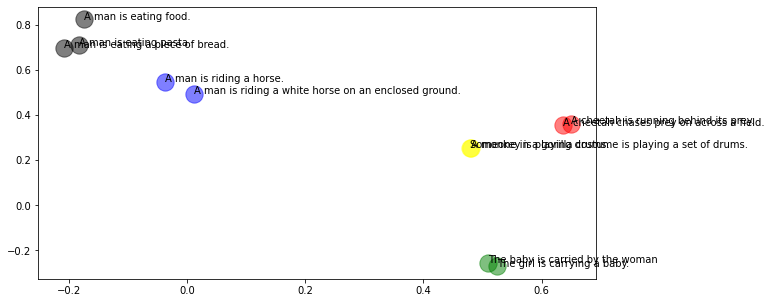

In [ ]:
corpus_embeddings_reduced = reduce_to_k_dim(corpus_embeddings, k=2)
plot_embeddings_sentences(corpus_embeddings_reduced, corpus, cluster_assignment)

In [ ]:
# Corpus with example sentences
corpus = ['A man is eating food.',
          'A man is eating a piece of bread.',
          'A man is eating pasta.',
          'The girl is carrying a baby.',
          'The baby is carried by the woman',
          'A man is riding a horse.',
          'A man is riding a white horse on an enclosed ground.',
          'A monkey is playing drums.',
          'Someone in a gorilla costume is playing a set of drums.',
          'A cheetah is running behind its prey.',
          'A cheetah chases prey on across a field.'
          ]
corpus_embeddings = embedder.encode(corpus)

# Normalize the embeddings to unit length
corpus_embeddings = corpus_embeddings /  np.linalg.norm(corpus_embeddings, axis=1, keepdims=True)

# Perform kmean clustering
clustering_model = AgglomerativeClustering(n_clusters=None, distance_threshold=1.5) #, affinity='cosine', linkage='average', distance_threshold=0.4)
clustering_model.fit(corpus_embeddings)
cluster_assignment = clustering_model.labels_

clustered_sentences = {}
for sentence_id, cluster_id in enumerate(cluster_assignment):
    if cluster_id not in clustered_sentences:
        clustered_sentences[cluster_id] = []

    clustered_sentences[cluster_id].append(corpus[sentence_id])

for i, cluster in clustered_sentences.items():
    print("Cluster ", i+1)
    print(cluster)
    print("")

Cluster  1
['A man is eating food.', 'A man is eating a piece of bread.', 'A man is eating pasta.']

Cluster  5
['The girl is carrying a baby.', 'The baby is carried by the woman']

Cluster  2
['A man is riding a horse.', 'A man is riding a white horse on an enclosed ground.']

Cluster  3
['A monkey is playing drums.', 'Someone in a gorilla costume is playing a set of drums.']

Cluster  4
['A cheetah is running behind its prey.', 'A cheetah chases prey on across a field.']



### Question 4.3: SentenceBERT Plot Analysis [written] (3 points)

Plot the above corpus with your favorite method in a 2-dimensional space. Comment on the output. 

Running Truncated SVD over 11 words...
Done.


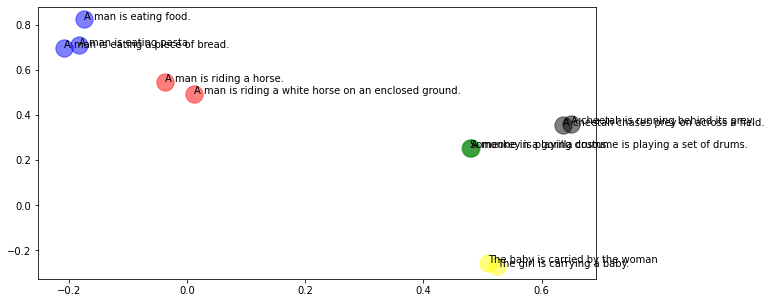

In [ ]:
corpus_embeddings_reduced = reduce_to_k_dim(corpus_embeddings, k=2)
plot_embeddings_sentences(corpus_embeddings_reduced, corpus, cluster_assignment)

### Question 4.4: Independent Analysis of Bias in Word Vectors [code + written] (4 points) 

Select a corpus of interest, or examples of interest and shed light on one source of bias from SentenceBERT.

In [ ]:
# Corpus with example sentences
corpus = ['The mayor gave a formal speech to its citizens',
          'The american soldier landed on the operation ground',
          'The nurse was very kind with her patient',
          'Despite the pregnancy, staff work was evaluated',
          'The civil servant finished the slides presentation after work',
          'The chief prepared a great meal for tonight celebrations',
          'The housekeeper cleaned the house and welcomed the guests',
          'The receptionist welcomed the customers well'
          ]
corpus_embeddings = embedder.encode(corpus)

# Perform kmean clustering
num_clusters = 2
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(corpus_embeddings)

cluster_assignment = clustering_model.labels_

clustered_sentences = {}
for sentence_id, cluster_id in enumerate(cluster_assignment):
    if cluster_id not in clustered_sentences:
        clustered_sentences[cluster_id] = []

    clustered_sentences[cluster_id].append(corpus[sentence_id])

for i, cluster in clustered_sentences.items():
    print("Cluster ", i+1)
    print(cluster)
    print("")

Cluster  2
['The mayor gave a formal speech to its citizens', 'The american soldier landed on the operation ground', 'The civil servant finished the slides presentation after work', 'The chief prepared a great meal for tonight celebrations']

Cluster  1
['The nurse was very kind with her patient', 'Despite the pregnancy, staff work was evaluated', 'The housekeeper cleaned the house and welcomed the guests', 'The receptionist welcomed the customers well']



Running Truncated SVD over 8 words...
Done.


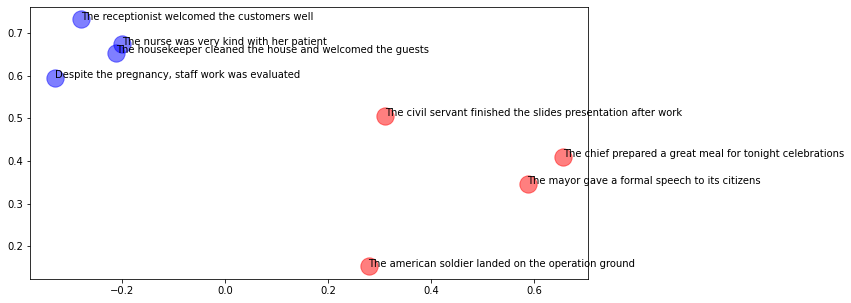

In [ ]:
corpus_embeddings_reduced = reduce_to_k_dim(corpus_embeddings, k=2)
plot_embeddings_sentences(corpus_embeddings_reduced, corpus, cluster_assignment)

* What we've tried to do with the corpus above, is to exhibit a sentence gender bias.
* The corpus consists of sentences that describe a work activity that may be classified as either "for woman" or "manly".
* The latter is as neutral as possible, we tried to avoid using some keywords that may bias the classification such as "man", "woman", "her", "his" and all the gender related pronouns.
* Since we already know that we want two clusters, and in a certain way forcing the biasing appearance.
* Hence using the `KMeans` clustering approach (with 2 clusters), which in this context is more relevant than `AgglomerativeClustering` (deduce implictly the cluster number).
* The results obtained are really compelling, for instance: "The receptionist welcomed the customers well" is not in the same cluster as "The american soldier landed on the operation ground".
* We can deduce from this, that the first sentence is considered as a "woman's job" and the other one as "manly".